<a href="https://colab.research.google.com/github/beyzaturku/runway_detection_and_segmentation/blob/main/segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **U-Net Model Eğitimi**

#### **Veri Ön İşleme**

In [2]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class RunwayDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Tüm görüntü dosyalarını al
        self.image_files = []

        # Sadece .png uzantılı dosyaları al (.mask.png hariç)
        all_files = os.listdir(image_dir)
        for file in all_files:
            if file.lower().endswith('.png') and not file.endswith('.mask.png'):
                # Karşılık gelen mask dosyasının var olup olmadığını kontrol et
                base_name = os.path.splitext(file)[0]  # .png'yi çıkar
                mask_file = base_name + '.mask.png'
                mask_path = os.path.join(mask_dir, mask_file)

                if os.path.exists(mask_path):
                    self.image_files.append(file)

        print(f"Found {len(self.image_files)} valid image-mask pairs")

        # İlk birkaç eşleşmeyi göster
        if len(self.image_files) > 0:
            print("Sample pairs:")
            for i in range(min(5, len(self.image_files))):
                img_file = self.image_files[i]
                mask_file = os.path.splitext(img_file)[0] + '.mask.png'
                print(f"  {i+1}. {img_file} -> {mask_file}")
        else:
            print("❌ No valid pairs found!")
            # Debug bilgisi
            print(f"Image directory contents (first 5): {all_files[:5]}")
            print(f"Mask directory contents (first 5): {os.listdir(mask_dir)[:5]}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Görüntü dosyası yolu
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)

        # Mask dosyası yolu
        mask_file = os.path.splitext(img_file)[0] + '.mask.png'
        mask_path = os.path.join(self.mask_dir, mask_file)

        # Görüntüyü yükle
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Mask'ı yükle
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")

        # Normalize et (0-1 arasına)
        image = image.astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)  # sadece 0 veya 1

        # Tensor'a çevir
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC -> CHW
        mask = torch.from_numpy(mask).unsqueeze(0)  # HW -> 1HW

        # Transform uygula (eğer varsa)
        if self.transform:
            # Transform'lar genelde PIL Image bekler, gerekirse çevir
            pass

        return image, mask

# Test fonksiyonu
def test_dataset(image_dir, mask_dir):
    """Dataset'i test et"""
    print("=== TESTING DATASET ===")

    try:
        dataset = RunwayDataset(image_dir, mask_dir)

        if len(dataset) == 0:
            print("❌ Dataset is empty!")
            return False

        print(f"✅ Dataset created successfully with {len(dataset)} samples")

        # İlk sample'ı test et
        print("\nTesting first sample...")
        sample_image, sample_mask = dataset[0]

        print(f"✅ Sample loaded successfully:")
        print(f"   Image shape: {sample_image.shape}")
        print(f"   Mask shape: {sample_mask.shape}")
        print(f"   Image dtype: {sample_image.dtype}")
        print(f"   Mask dtype: {sample_mask.dtype}")
        print(f"   Image range: [{sample_image.min():.3f}, {sample_image.max():.3f}]")
        print(f"   Mask range: [{sample_mask.min():.3f}, {sample_mask.max():.3f}]")

        # DataLoader ile test
        from torch.utils.data import DataLoader

        print("\nTesting with DataLoader...")
        dataloader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)

        batch = next(iter(dataloader))
        batch_images, batch_masks = batch

        print(f"✅ DataLoader test successful:")
        print(f"   Batch image shape: {batch_images.shape}")
        print(f"   Batch mask shape: {batch_masks.shape}")

        return True

    except Exception as e:
        print(f"❌ Dataset test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# Kullanım
if __name__ == "__main__":
    image_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG"
    mask_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG"

    # Dataset'i test et
    success = test_dataset(image_dir, mask_dir)

    if success:
        print("\n🎉 Dataset is ready for training!")
    else:
        print("\n❌ Dataset needs fixing before training.")

=== TESTING DATASET ===
Found 6498 valid image-mask pairs
Sample pairs:
  1. tP_Z2rGUAWE_088__day_4.png -> tP_Z2rGUAWE_088__day_4.mask.png
  2. rjWG3WRM5yk_066__day_4.png -> rjWG3WRM5yk_066__day_4.mask.png
  3. tP_Z2rGUAWE_089__day_4.png -> tP_Z2rGUAWE_089__day_4.mask.png
  4. tP_Z2rGUAWE_088__night_2.png -> tP_Z2rGUAWE_088__night_2.mask.png
  5. tP_Z2rGUAWE_089__fog_0.png -> tP_Z2rGUAWE_089__fog_0.mask.png
✅ Dataset created successfully with 6498 samples

Testing first sample...
✅ Sample loaded successfully:
   Image shape: torch.Size([3, 1024, 1024])
   Mask shape: torch.Size([1, 1024, 1024])
   Image dtype: torch.float32
   Mask dtype: torch.float32
   Image range: [0.000, 1.000]
   Mask range: [0.000, 1.000]

Testing with DataLoader...
✅ DataLoader test successful:
   Batch image shape: torch.Size([2, 3, 1024, 1024])
   Batch mask shape: torch.Size([2, 1, 1024, 1024])

🎉 Dataset is ready for training!


#### **U-Net Model Mimarisi**

In [6]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)

        self.final = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))

        # Bottleneck
        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        # Decoder path with skip connections
        d4 = self.dec4(torch.cat([nn.Upsample(scale_factor=2)(b), e4], 1))
        d3 = self.dec3(torch.cat([nn.Upsample(scale_factor=2)(d4), e3], 1))
        d2 = self.dec2(torch.cat([nn.Upsample(scale_factor=2)(d3), e2], 1))
        d1 = self.dec1(torch.cat([nn.Upsample(scale_factor=2)(d2), e1], 1))

        return self.final(d1)

#### **Model Eğitimi**

In [8]:
"""import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import warnings

def train_unet_optimized(image_dir, mask_dir, epochs=20, batch_size=8,
                        max_batches_per_epoch=500, learning_rate=0.0001):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 Training on device: {device}")

    # GPU memory info
    if device.type == 'cuda':
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")
        torch.cuda.empty_cache()

    try:
        # Dataset oluştur
        dataset = RunwayDataset(image_dir, mask_dir)
        if len(dataset) == 0:
            raise ValueError("Dataset is empty!")

        print(f"✅ Dataset: {len(dataset)} samples")

        # DataLoader - optimize edilmiş settings
        train_loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True,
            drop_last=True,
            persistent_workers=True
        )

        total_batches = len(train_loader)
        batches_per_epoch = min(max_batches_per_epoch, total_batches)

        print(f"📊 Training Setup:")
        print(f"   Batch size: {batch_size}")
        print(f"   Total batches available: {total_batches}")
        print(f"   Batches per epoch: {batches_per_epoch}")
        print(f"   Learning rate: {learning_rate}")
        print(f"   Estimated time per epoch: {batches_per_epoch * 0.5 / 60:.1f} min")

        # Model
        model = UNet().to(device)

        def init_weights(m):
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        model.apply(init_weights)

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=1e-4,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        warmup_epochs = 2
        warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=0.1, total_iters=warmup_epochs
        )

        main_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3,
            verbose=True, min_lr=1e-7
        )

        class SmoothBCEWithLogitsLoss(nn.Module):
            def __init__(self, smoothing=0.1):
                super().__init__()
                self.smoothing = smoothing
                self.bce = nn.BCEWithLogitsLoss()

            def forward(self, pred, target):
                target_smooth = target * (1 - self.smoothing) + 0.5 * self.smoothing
                return self.bce(pred, target_smooth)

        criterion = SmoothBCEWithLogitsLoss(smoothing=0.05)

        scaler = GradScaler() if device.type == 'cuda' else None

        best_loss = float('inf')
        nan_count = 0
        loss_history = []

        print(f"\n🏃‍♂️ Starting gradient-explosion-safe training...")

        for epoch in range(epochs):
            model.train()
            epoch_start_time = time.time()

            total_loss = 0
            processed_batches = 0
            valid_batches = 0

            data_iter = iter(train_loader)

            for batch_idx in range(batches_per_epoch):
                try:
                    data, target = next(data_iter)
                except StopIteration:
                    data_iter = iter(train_loader)
                    data, target = next(data_iter)

                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

                if torch.isnan(data).any() or torch.isnan(target).any():
                    print(f"⚠️  NaN detected in input data at batch {batch_idx}")
                    continue

                if data.abs().max() > 10 or target.abs().max() > 1:
                    print(f"⚠️  Unusual data range detected: data_max={data.abs().max():.2f}, target_max={target.abs().max():.2f}")

                optimizer.zero_grad()

                if scaler is not None:
                    with autocast():
                        output = model(data)
                        loss = criterion(output, target)

                    # NaN kontrolü
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"🚨 NaN/Inf loss detected at epoch {epoch+1}, batch {batch_idx}")
                        nan_count += 1

                        if nan_count > 5:
                            print("🛑 Too many NaN losses, stopping training")
                            break

                        continue

                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)

                    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    if total_norm > 10.0:
                        print(f"⚠️  High gradient norm detected: {total_norm:.2f}")
                        # Daha agresif clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

                    scaler.step(optimizer)
                    scaler.update()

                else:
                    output = model(data)
                    loss = criterion(output, target)

                    # NaN kontrolü
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"🚨 NaN/Inf loss detected at epoch {epoch+1}, batch {batch_idx}")
                        nan_count += 1
                        continue

                    loss.backward()

                    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                    if total_norm > 10.0:
                        print(f"⚠️  High gradient norm detected: {total_norm:.2f}")
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

                    optimizer.step()

                total_loss += loss.item()
                processed_batches += 1
                valid_batches += 1

                loss_history.append(loss.item())

                # Son 10 batch'in ortalaması ile ani sıçrama kontrolü
                if len(loss_history) > 10:
                    recent_avg = np.mean(loss_history[-10:])
                    if len(loss_history) > 20:
                        prev_avg = np.mean(loss_history[-20:-10])
                        if recent_avg > prev_avg * 2:
                            print(f"⚠️  Sudden loss increase detected: {prev_avg:.4f} -> {recent_avg:.4f}")
                            # Learning rate'i geçici olarak düşür
                            for param_group in optimizer.param_groups:
                                param_group['lr'] *= 0.5
                            print(f"📉 Learning rate reduced to: {optimizer.param_groups[0]['lr']:.6f}")

                if batch_idx % 50 == 0 or batch_idx < 10:
                    elapsed = time.time() - epoch_start_time
                    eta = (elapsed / (batch_idx + 1)) * (batches_per_epoch - batch_idx - 1)

                    grad_norm_info = f", Grad_norm: {total_norm:.2f}" if 'total_norm' in locals() else ""

                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{batches_per_epoch}, '
                          f'Loss: {loss.item():.4f}, ETA: {eta/60:.1f}min{grad_norm_info}')

            # Epoch tamamlandıktan sonra kontroller
            if valid_batches == 0:
                print(f"❌ No valid batches in epoch {epoch+1}")
                break

            # Epoch özeti
            avg_loss = total_loss / valid_batches
            epoch_time = time.time() - epoch_start_time

            print(f'✅ Epoch {epoch+1}/{epochs} completed in {epoch_time/60:.1f}min')
            print(f'   Average Loss: {avg_loss:.4f}')
            print(f'   Valid batches: {valid_batches}/{processed_batches}')
            print(f'   Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
            print(f'   NaN count: {nan_count}')

            if epoch < warmup_epochs:
                warmup_scheduler.step()
                print(f"   Warmup phase: LR = {optimizer.param_groups[0]['lr']:.6f}")
            else:
                main_scheduler.step(avg_loss)

            if avg_loss < best_loss and not np.isnan(avg_loss):
                best_loss = avg_loss
                best_model_path = 'unet_runway_best.pth'
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_loss,
                    'best_loss': best_loss
                }, best_model_path)
                print(f"🏆 New best model saved: {best_model_path}")

            if (epoch + 1) % 3 == 0:
                save_path = f'unet_runway_epoch_{epoch+1}.pth'
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_loss,
                    'nan_count': nan_count,
                    'loss_history': loss_history[-100:]  # Son 100 loss değeri
                }, save_path)
                print(f"💾 Checkpoint saved: {save_path}")

            if np.isnan(avg_loss):
                print(f"🛑 Training stopped due to NaN loss")
                break

            if avg_loss > 5.0:
                print(f"⚠️  Warning: High loss detected ({avg_loss:.2f})")
                print("Consider further reducing learning rate")

            if nan_count > 10:
                print(f"🛑 Training stopped due to too many NaN occurrences ({nan_count})")
                break

        # Final model
        final_path = 'unet_runway_final.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'training_completed': True,
            'final_loss': avg_loss,
            'best_loss': best_loss,
            'total_nan_count': nan_count,
            'loss_history': loss_history
        }, final_path)

        print(f"🎉 Training completed! Model saved: {final_path}")
        print(f"📊 Final stats: Best Loss: {best_loss:.4f}, NaN count: {nan_count}")

        return model

    except Exception as e:
        print(f"❌ Training error: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_validation(model, dataset, device, num_samples=50):
    """NaN-safe validation"""
    model.eval()
    val_loader = DataLoader(dataset, batch_size=4, shuffle=True)

    total_loss = 0
    valid_samples = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            if valid_samples >= num_samples:
                break

            # NaN kontrolü
            if torch.isnan(data).any() or torch.isnan(target).any():
                continue

            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            # NaN loss kontrolü
            if torch.isnan(loss) or torch.isinf(loss):
                continue

            total_loss += loss.item()
            valid_samples += data.shape[0]

    if valid_samples > 0:
        avg_loss = total_loss / valid_samples * data.shape[0]  # Batch sayısına göre düzelt
        print(f"📊 Quick validation loss: {avg_loss:.4f} (valid samples: {valid_samples})")
    else:
        avg_loss = float('inf')
        print(f"⚠️  No valid validation samples")

    return avg_loss

# Güvenli başlatma fonksiyonları
def start_safe_training():
    image_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG"
    mask_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG"

    print("🛡️  SAFE TRAINING MODE - Gradient Explosion Protected")
    print("=" * 60)

    model = train_unet_optimized(
        image_dir=image_dir,
        mask_dir=mask_dir,
        epochs=10,
        batch_size=8,
        max_batches_per_epoch=300,
        learning_rate=0.0001  # Daha düşük LR
    )

    return model"""

"""def recovery_training(checkpoint_path):
    print(f"🔄 Recovering training from: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    # Model'i yükle
    model = UNet()
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint.get('epoch', 'Unknown')}")
    print(f"   Loss: {checkpoint.get('loss', 'Unknown')}")
    print(f"   NaN count: {checkpoint.get('nan_count', 'Unknown')}")

    return model"""

In [9]:
"""model = start_safe_training()"""

🛡️  SAFE TRAINING MODE - Gradient Explosion Protected
🚀 Training on device: cuda
GPU Memory: 42.5GB
Found 6498 valid image-mask pairs
Sample pairs:
  1. tP_Z2rGUAWE_088__day_4.png -> tP_Z2rGUAWE_088__day_4.mask.png
  2. rjWG3WRM5yk_066__day_4.png -> rjWG3WRM5yk_066__day_4.mask.png
  3. tP_Z2rGUAWE_089__day_4.png -> tP_Z2rGUAWE_089__day_4.mask.png
  4. tP_Z2rGUAWE_088__night_2.png -> tP_Z2rGUAWE_088__night_2.mask.png
  5. tP_Z2rGUAWE_089__fog_0.png -> tP_Z2rGUAWE_089__fog_0.mask.png
✅ Dataset: 6498 samples
📊 Training Setup:
   Batch size: 8
   Total batches available: 812
   Batches per epoch: 300
   Learning rate: 0.0001
   Estimated time per epoch: 2.5 min

🏃‍♂️ Starting gradient-explosion-safe training...


<ipython-input-8-ff3ea45dbd2b>:93: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' else None
<ipython-input-8-ff3ea45dbd2b>:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


⚠️  High gradient norm detected: inf
Epoch 1/10, Batch 0/300, Loss: 0.4064, ETA: 20.9min, Grad_norm: inf
⚠️  High gradient norm detected: 37.86
Epoch 1/10, Batch 1/300, Loss: 0.4642, ETA: 11.6min, Grad_norm: 37.86
Epoch 1/10, Batch 2/300, Loss: 0.3293, ETA: 10.6min, Grad_norm: 4.87
Epoch 1/10, Batch 3/300, Loss: 0.3065, ETA: 8.5min, Grad_norm: 4.97
Epoch 1/10, Batch 4/300, Loss: 0.2838, ETA: 9.4min, Grad_norm: 4.09
Epoch 1/10, Batch 5/300, Loss: 0.2235, ETA: 8.2min, Grad_norm: 2.86
⚠️  High gradient norm detected: 10.36
Epoch 1/10, Batch 6/300, Loss: 0.2864, ETA: 7.4min, Grad_norm: 10.36
Epoch 1/10, Batch 7/300, Loss: 0.3082, ETA: 6.8min, Grad_norm: 7.91
Epoch 1/10, Batch 8/300, Loss: 0.2288, ETA: 37.8min, Grad_norm: 4.00
Epoch 1/10, Batch 9/300, Loss: 0.2330, ETA: 34.5min, Grad_norm: 3.72
⚠️  High gradient norm detected: 12.69
⚠️  High gradient norm detected: 12.00
⚠️  High gradient norm detected: 12.24
⚠️  High gradient norm detected: 18.21
⚠️  High gradient norm detected: 39.97
⚠️  

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time

def simple_unet_training(image_dir, mask_dir, epochs=10, batch_size=4, learning_rate=0.0001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # Dataset
    dataset = RunwayDataset(image_dir, mask_dir)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Dataset: {len(dataset)} samples")
    print(f"Batches per epoch: {len(train_loader)}")

    # Model
    model = UNet().to(device)

    # Optimizer - düşük learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    print(f"Starting training with LR: {learning_rate}")
    print("-" * 50)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            # NaN kontrolü
            if torch.isnan(loss):
                print(f"NaN loss detected at batch {batch_idx}, skipping...")
                continue

            # Backward pass
            loss.backward()

            # Gradient clipping - basit koruma
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()

            # Progress her 50 batch'te
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Epoch summary
        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}, Time: {epoch_time:.1f}s')

        # Model kaydet (her 3 epoch)
        if (epoch + 1) % 3 == 0:
            torch.save(model.state_dict(), f'unet_epoch_{epoch+1}.pth')
            print(f'Model saved: unet_epoch_{epoch+1}.pth')

    # Final model
    torch.save(model.state_dict(), 'unet_final.pth')
    print("Training completed! Final model saved.")

    return model

# Basit başlatma
def start_training():
    image_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG"
    mask_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG"

    model = simple_unet_training(
        image_dir=image_dir,
        mask_dir=mask_dir,
        epochs=10,
        batch_size=4,
        learning_rate=0.0001  # Düşük LR - gradient explosion önlemi
    )

    return model

In [18]:
model = start_training()

Device: cuda
Found 6498 valid image-mask pairs
Sample pairs:
  1. tP_Z2rGUAWE_088__day_4.png -> tP_Z2rGUAWE_088__day_4.mask.png
  2. rjWG3WRM5yk_066__day_4.png -> rjWG3WRM5yk_066__day_4.mask.png
  3. tP_Z2rGUAWE_089__day_4.png -> tP_Z2rGUAWE_089__day_4.mask.png
  4. tP_Z2rGUAWE_088__night_2.png -> tP_Z2rGUAWE_088__night_2.mask.png
  5. tP_Z2rGUAWE_089__fog_0.png -> tP_Z2rGUAWE_089__fog_0.mask.png
Dataset: 6498 samples
Batches per epoch: 1625
Starting training with LR: 0.0001
--------------------------------------------------
Epoch 1/10, Batch 0/1625, Loss: 0.7112
Epoch 1/10, Batch 50/1625, Loss: 0.1719
Epoch 1/10, Batch 100/1625, Loss: 0.0773
Epoch 1/10, Batch 150/1625, Loss: 0.0859
Epoch 1/10, Batch 200/1625, Loss: 0.1028
Epoch 1/10, Batch 250/1625, Loss: 0.2635
Epoch 1/10, Batch 300/1625, Loss: 0.0714
Epoch 1/10, Batch 350/1625, Loss: 0.1188
Epoch 1/10, Batch 400/1625, Loss: 0.1303
Epoch 1/10, Batch 450/1625, Loss: 0.1153
Epoch 1/10, Batch 500/1625, Loss: 0.0327
Epoch 1/10, Batch 550

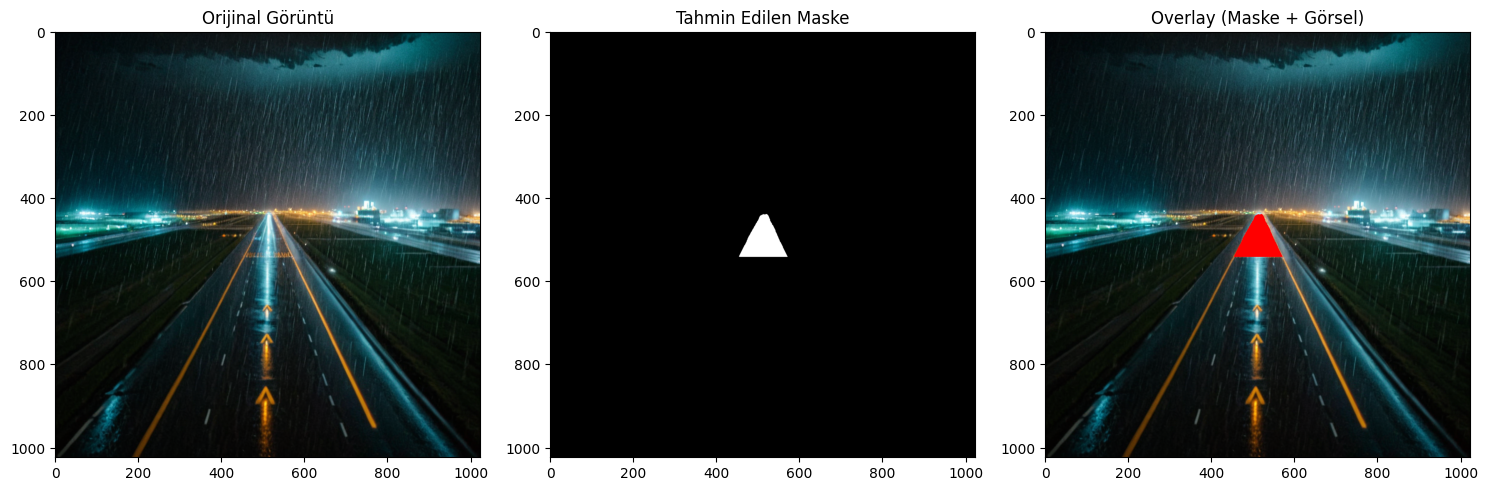

True

In [34]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Cihaz seçimi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)  # UNet zaten tanımlıysa
model.load_state_dict(torch.load("/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/unet_final.pth", map_location=device)) # Doğrudan state_dict'i yükle
model.eval()

def load_test_image(image_path):
    # Görseli yükle ve RGB'ye çevir
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize et
    image = image.astype(np.float32) / 255.0

    # Tensor formatına dönüştür
    tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)  # [1, 3, H, W]
    return tensor.to(device), image  # Tensor + orijinal görsel (görselleştirme için)

def predict_single(model, tensor_input):
    with torch.no_grad():
        output = model(tensor_input)  # [1, 1, H, W]
        prob_map = torch.sigmoid(output).squeeze().cpu().numpy()  # [H, W] aralığı [0,1]
        mask = (prob_map > 0.5).astype(np.uint8)  # Binary maske
        return mask, prob_map

def visualize_result(original_image, predicted_mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Orijinal Görüntü")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Tahmin Edilen Maske")

    plt.subplot(1, 3, 3)
    overlay = original_image.copy()
    overlay[predicted_mask == 1] = [255, 0, 0]  # Kırmızı overlay
    plt.imshow(overlay)
    plt.title("Overlay (Maske + Görsel)")

    plt.tight_layout()
    plt.show()

# Görsel yolunu ver
test_image_path = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG/3s1eHvzkxxI_095__rain+night_0.png"

# Görseli yükle
tensor_input, original = load_test_image(test_image_path)

# Tahmin
pred_mask, prob_map = predict_single(model, tensor_input)

# Sonuç göster
visualize_result(original, pred_mask)

cv2.imwrite("/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/output_test.png", pred_mask * 255)


In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calculate_metrics(predictions, targets, threshold=0.5):
    """
    Segmentation metrikleri hesapla
    """
    # Sigmoid uygula ve threshold
    pred_binary = (torch.sigmoid(predictions) > threshold).float()

    # Flatten tensors
    pred_flat = pred_binary.view(-1)
    target_flat = targets.view(-1)

    # Temel metrikler
    tp = ((pred_flat == 1) & (target_flat == 1)).sum().item()
    tn = ((pred_flat == 0) & (target_flat == 0)).sum().item()
    fp = ((pred_flat == 1) & (target_flat == 0)).sum().item()
    fn = ((pred_flat == 0) & (target_flat == 1)).sum().item()

    # Metrik hesaplamaları
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # IoU (Intersection over Union) - segmentation için önemli
    intersection = tp
    union = tp + fp + fn
    iou = intersection / union if union > 0 else 0

    # Dice Score - segmentation için çok önemli
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'iou': iou,
        'dice_score': dice,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

def evaluate_model(model_path, dataset, device, model_name="Model"):
    """
    Tek bir model değerlendir
    """
    print(f"\n📊 Evaluating {model_name}...")

    # Model yükle
    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Test dataloader
    test_loader = DataLoader(dataset, batch_size=8, shuffle=False)

    all_metrics = []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Prediction
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Her image için metrik hesapla
            for i in range(images.size(0)):
                metrics = calculate_metrics(outputs[i:i+1], masks[i:i+1])
                all_metrics.append(metrics)

    # Ortalama metrikleri hesapla
    avg_metrics = {}
    metric_keys = ['accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice_score']

    for key in metric_keys:
        values = [m[key] for m in all_metrics if not np.isnan(m[key])]
        avg_metrics[key] = np.mean(values) if values else 0

    avg_metrics['avg_loss'] = total_loss / len(test_loader)

    return avg_metrics, all_metrics

def compare_models(model_paths, dataset, device):
    """
    Tüm modelleri karşılaştır
    """
    print("🔍 U-Net Model Comparison")
    print("=" * 50)

    results = {}

    # Her model için evaluation
    for model_name, model_path in model_paths.items():
        try:
            avg_metrics, _ = evaluate_model(model_path, dataset, device, model_name)
            results[model_name] = avg_metrics

            # Sonuçları yazdır
            print(f"\n{model_name} Results:")
            print(f"  📏 Accuracy:    {avg_metrics['accuracy']:.4f}")
            print(f"  🎯 Precision:   {avg_metrics['precision']:.4f}")
            print(f"  📈 Recall:      {avg_metrics['recall']:.4f}")
            print(f"  ⚖️  F1-Score:    {avg_metrics['f1_score']:.4f}")
            print(f"  🔲 IoU:         {avg_metrics['iou']:.4f}")
            print(f"  🎲 Dice Score:  {avg_metrics['dice_score']:.4f}")
            print(f"  📉 Avg Loss:    {avg_metrics['avg_loss']:.4f}")

        except Exception as e:
            print(f"❌ Error evaluating {model_name}: {e}")

    return results

def plot_comparison(results):
    """
    Karşılaştırma grafikleri çiz
    """
    if not results:
        print("No results to plot!")
        return

    # Metrikleri organize et
    models = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'iou', 'dice_score']

    # 2x3 subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('U-Net Model Performance Comparison', fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i//3, i%3]

        values = [results[model][metric] for model in models]
        bars = ax.bar(models, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])

        # En iyi modeli vurgula
        best_idx = np.argmax(values)
        bars[best_idx].set_color('#FFD93D')

        ax.set_title(metric.replace('_', ' ').title())
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)

        # Değerleri bar üzerine yaz
        for j, v in enumerate(values):
            ax.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # En iyi model
    best_model = max(results.keys(), key=lambda x: results[x]['dice_score'])
    print(f"\n🏆 Best Model: {best_model}")
    print(f"   Dice Score: {results[best_model]['dice_score']:.4f}")

def detailed_analysis(model_path, dataset, device, num_samples=5):
    """
    Detaylı analiz ve görselleştirme
    """
    print(f"\n🔬 Detailed Analysis")

    model = UNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    plt.figure(figsize=(15, num_samples * 3))

    with torch.no_grad():
        for idx, (image, mask) in enumerate(test_loader):
            if idx >= num_samples:
                break

            image = image.to(device)
            mask = mask.to(device)

            # Prediction
            output = model(image)
            pred_mask = torch.sigmoid(output) > 0.5

            # Metrikler
            metrics = calculate_metrics(output, mask)

            # Visualize
            plt.subplot(num_samples, 3, idx*3 + 1)
            plt.imshow(image[0, 0].cpu(), cmap='gray')
            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(num_samples, 3, idx*3 + 2)
            plt.imshow(mask[0, 0].cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')

            plt.subplot(num_samples, 3, idx*3 + 3)
            plt.imshow(pred_mask[0, 0].cpu(), cmap='gray')
            plt.title(f'Prediction\nDice: {metrics["dice_score"]:.3f}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Ana evaluation fonksiyonu
def run_evaluation():
    """
    Tüm evaluation'ı çalıştır
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Dataset (test için)
    image_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG"
    mask_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG"
    test_dataset = RunwayDataset(image_dir, mask_dir)

    # Model paths
    model_paths = {
        'Epoch 3': '/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/unet_epoch_3.pth',
        'Epoch 6': '/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/unet_epoch_6.pth',
        'Epoch 9': '/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/unet_epoch_9.pth',
        'Final': '/content/drive/MyDrive/runway_detection_and_tracking/segmentation_train_models/unet_final.pth'
    }

    # Karşılaştırma
    results = compare_models(model_paths, test_dataset, device)

    # Grafik çiz
    plot_comparison(results)

    # En iyi model için detaylı analiz
    if results:
        best_model_name = max(results.keys(), key=lambda x: results[x]['dice_score'])
        best_model_path = model_paths[best_model_name]
        detailed_analysis(best_model_path, test_dataset, device)

    return results

# Tek model evaluation
def evaluate_single_model(model_path):
    """
    Tek bir modeli hızlıca değerlendir
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/PNG"
    mask_dir = "/content/drive/MyDrive/runway_detection_and_tracking/split_dataset/MASK_PNG"
    dataset = RunwayDataset(image_dir, mask_dir)

    avg_metrics, _ = evaluate_model(model_path, dataset, device)

    return avg_metrics

Found 6498 valid image-mask pairs
Sample pairs:
  1. tP_Z2rGUAWE_088__day_4.png -> tP_Z2rGUAWE_088__day_4.mask.png
  2. rjWG3WRM5yk_066__day_4.png -> rjWG3WRM5yk_066__day_4.mask.png
  3. tP_Z2rGUAWE_089__day_4.png -> tP_Z2rGUAWE_089__day_4.mask.png
  4. tP_Z2rGUAWE_088__night_2.png -> tP_Z2rGUAWE_088__night_2.mask.png
  5. tP_Z2rGUAWE_089__fog_0.png -> tP_Z2rGUAWE_089__fog_0.mask.png
🔍 U-Net Model Comparison

📊 Evaluating Epoch 3...

Epoch 3 Results:
  📏 Accuracy:    0.9968
  🎯 Precision:   0.8134
  📈 Recall:      0.9123
  ⚖️  F1-Score:    0.8390
  🔲 IoU:         0.7783
  🎲 Dice Score:  0.8390
  📉 Avg Loss:    0.0094

📊 Evaluating Epoch 6...

Epoch 6 Results:
  📏 Accuracy:    0.9989
  🎯 Precision:   0.9489
  📈 Recall:      0.9522
  ⚖️  F1-Score:    0.9462
  🔲 IoU:         0.9176
  🎲 Dice Score:  0.9462
  📉 Avg Loss:    0.0033

📊 Evaluating Epoch 9...

Epoch 9 Results:
  📏 Accuracy:    0.9993
  🎯 Precision:   0.9422
  📈 Recall:      0.9599
  ⚖️  F1-Score:    0.9465
  🔲 IoU:         0.91

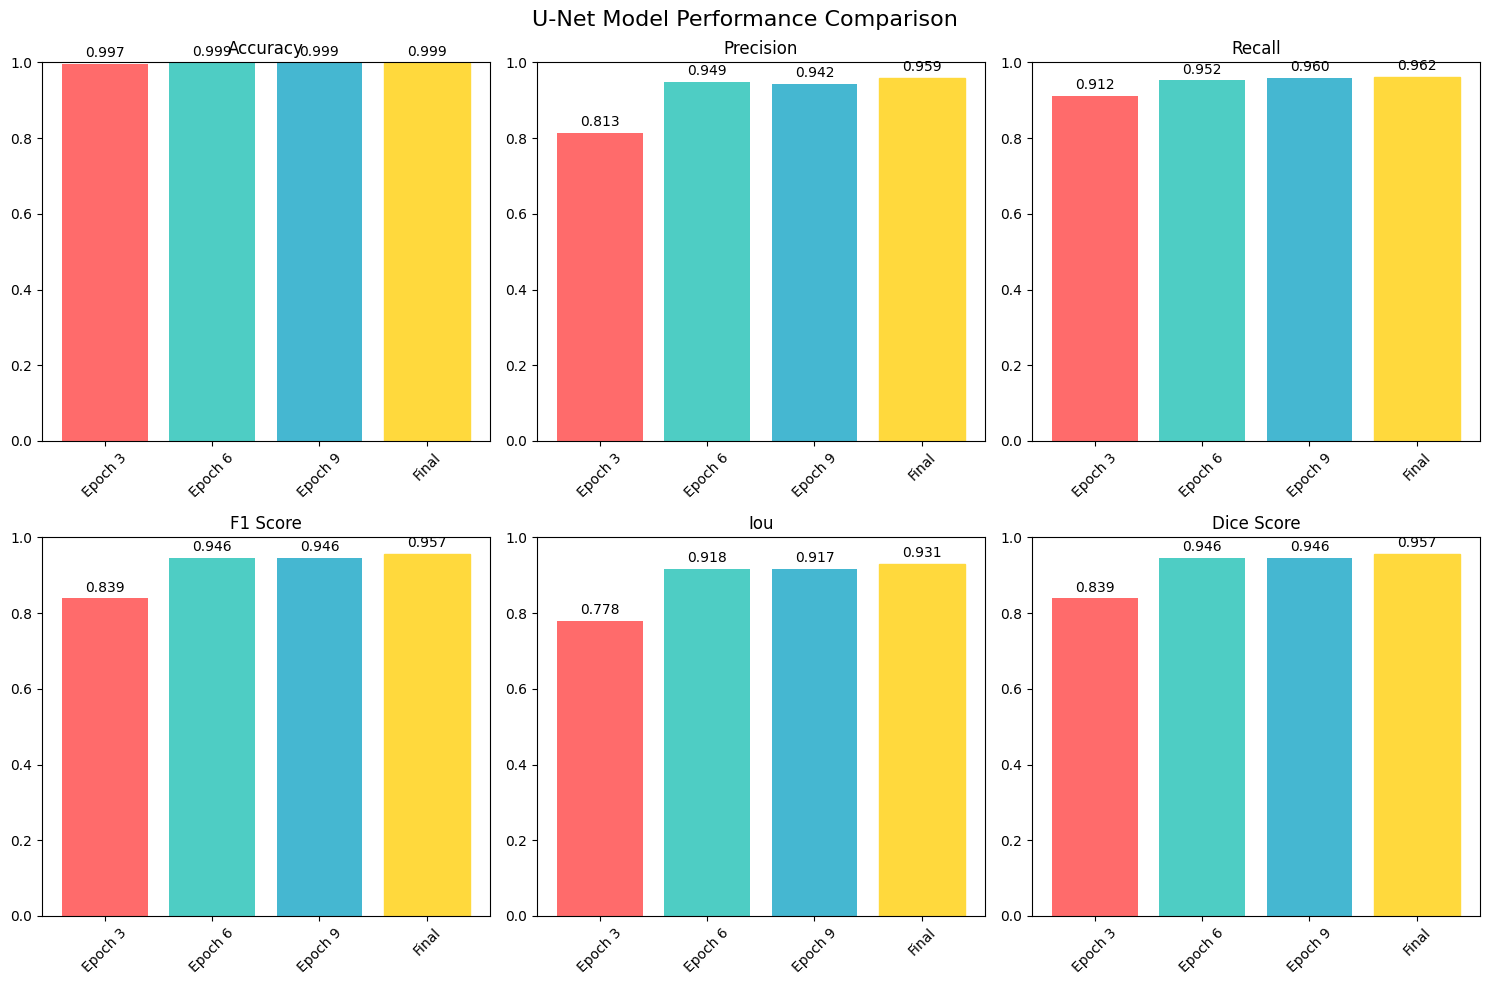


🏆 Best Model: Final
   Dice Score: 0.9567

🔬 Detailed Analysis


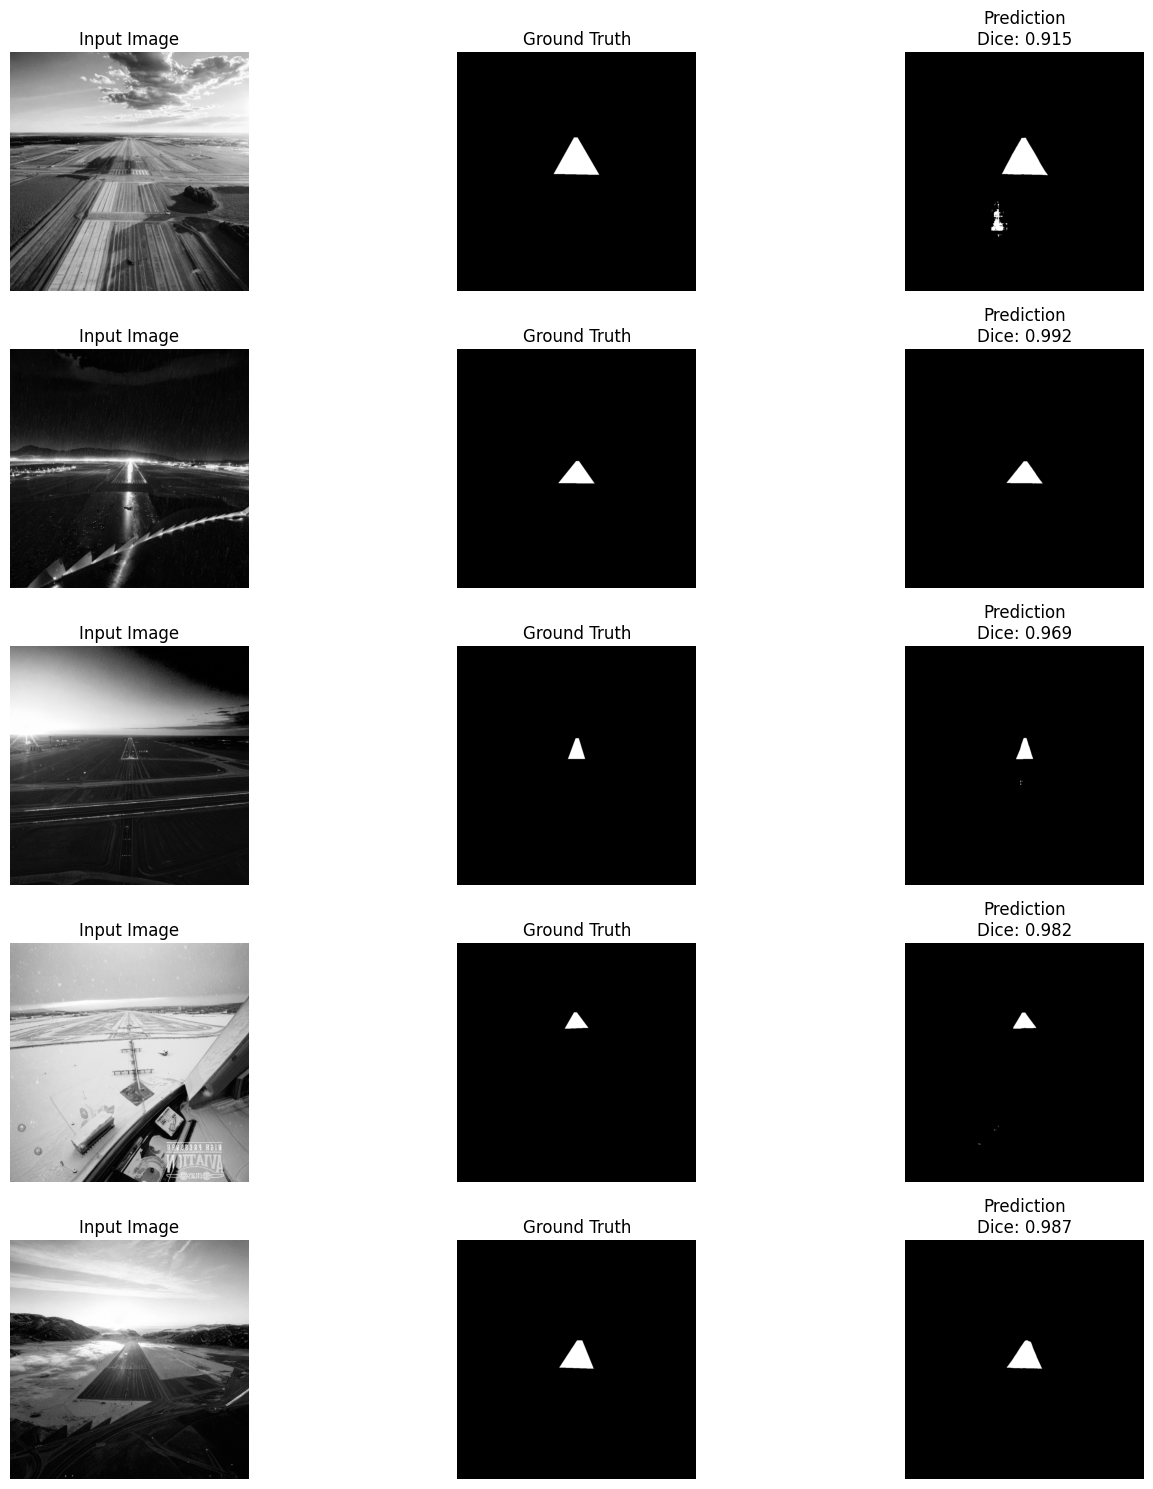

In [38]:
# Tüm evaluation'ı çalıştır
results = run_evaluation()